<a href="https://colab.research.google.com/github/dksifoua/Reinforcement-Learning/blob/master/notebooks/00%20-%20Sequential%20Decision%20Making%20Under%20Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
if [ -n "$COLAB_RELEASE_TAG" ]; then
  git clone https://github.com/dksifoua/Reinforcement-Learning.git
fi

In [2]:
import os

if os.environ.get("COLAB_RELEASE_TAG") is not None:
    os.chdir("./Reinforcement-Learning")
elif str(os.getcwd()).endswith("notebooks"):
    os.chdir("../")
else:
    pass

print("Current working directory:", os.getcwd())

Current working directory: /Users/dksifoua/Developer/learning/Reinforcement-Learning


# Introduction to Sequential Decision Making Under Uncertainty

In reinforcement learning, an agent generates its own training data by interacting with the world. Unlike supervised learning, where correct actions are provided, the agent must discover the consequences of its actions through trial and error. We introduce the fundamentals of reinforcement learning (RL) by focusing on the evaluative aspect of decision-making under uncertainty. We'll explore how agents learn from interactions with their environment, emphasizing key concepts like rewards, timesteps, and values. The core framework is the k-armed bandit problem, a simplified setting that captures essential RL ideas.
___

In [21]:
%load_ext autoreload
%autoreload 2

import tqdm
import numpy as np
from typing import List, Optional, Tuple

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from rl.bandit.agent import BanditAgent, BanditStepSizeAgent, BanditOptimisticAgent, BanditUCBAgent, BanditGradientAgent
from rl.bandit.environment import BanditEnvironment, BanditNonStationaryEnvironment
from rl.bandit.experiment import BanditExperiment
from rl.bandit.utils import plot_bandit_reward_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The K-Armed Bandit problem

In a k-armed bandit problem, an **agent** is faced repeatedly with a choice among k different **actions**. After taking each action, it receives a numerical **reward** chosen from a **stationary probability distribution** that depends on the selected action. The objective is **to maximize the expected total reward over some time period**, for example, over 1000 action selections, or **time steps**.

Each of the k actions has an expected or mean reward given that that action is selected; let us call this the **value** of that action. We denote the action selected on time step $t$ as $A_t$, and the corresponding reward as $R_t$. The value of an arbitrary action $a$, denoted $q_*(a)$, is the expected reward given that a is selected:

$$ q_*(a) \; \dot{=} \; \mathbb{E}[R_t|A_t = a] $$

In the k-armed bandit setting, we do not know the action values with certainty (although you may have estimates). We denote the estimated value of action $a$ at time step $t$ as $Q_t(a)$. We would like $Q_t(a)$ to be close to $q_*(a)$. With action values been estimated, we called **greedy actions** those with the highest estimates. Selecting a greedy action **exploits** current knowledge for immediate reward maximization. Conversely, choosing a non-greedy action **explores** to refine estimates, potentially yielding higher long-term rewards by uncovering superior options. Exploration is valuable when uncertainty exists and many future opportunities remain. Since a single choice can’t both explore and exploit, there is an inherent conflict between the two strategies.

The decision to explore or exploit in a given scenario heavily relies on action value estimates, their uncertainties, and remaining time steps. While advanced methods exist to balance this in k-armed bandit problems and variants, they often rely on unrealistic assumptions like stationarity and prior knowledge, which fail in real-world applications or broader reinforcement learning contexts, rendering their optimality guarantees unreliable.
___

In [10]:
N_ACTIONS = 10
SEED = 123

An example bandit problem of 10 arms. The true value $q_*(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean $q_*(a)$ unit variance normal distribution, as suggested by these distributions.
___

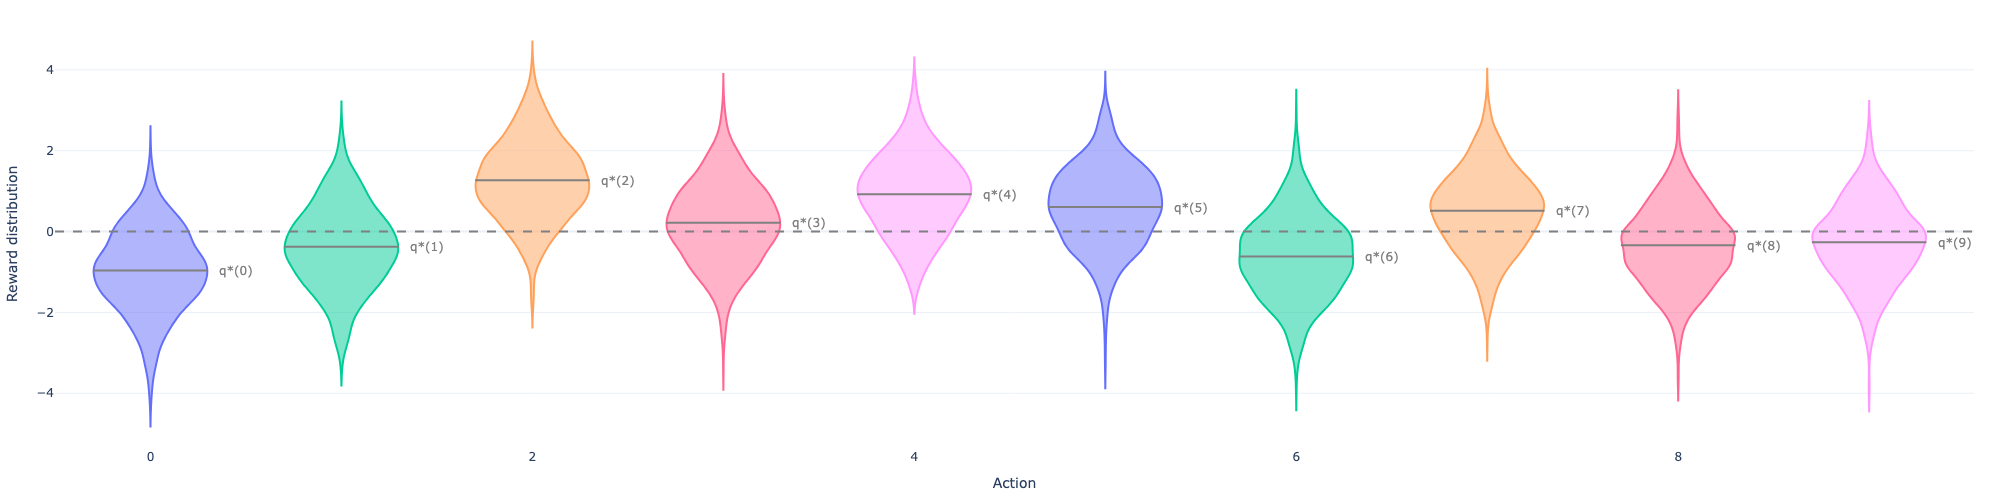

In [11]:
plot_bandit_reward_distribution(n_actions=N_ACTIONS, n_steps=1_000, seed=SEED)

## 2. Action-Value Methods

### 2.1. Sampling Average Methods

Action-Value methods estimates action values in order to make action selection decisions. Recall that the true value of an action is the mean reward when that action is selected:

$$
Q_t(a) \; \dot{=} \; \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{number of times $a$ taken prior to $t$}} \; 
= \; \frac{\sum_{i = 1}^{t - 1} R_i \cdot \mathbb{I}_{A_i = a}}{\sum_{i = 1}^{t - 1} \mathbb{I}_{A_i = a}},
$$

where $\mathbb{I}_{predicate}$ denotes the random variable that is $1$ if predicate is true and $0$ if it is not. If the denominator is zero, then we instead define $Q_t(a)$ as some default value, such as $0$. As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$. We call this the **sample-average method** for estimating action values because each estimate is an average of the sample of relevant rewards.

#### 2.1.1. Greedy Action Selection

Now that we have estimated the action values, the simplest action selection rule is to select one of the actions with the highest estimated value (**greedy action selection**). If there is more than one greedy action, then a selection is made among them in some arbitrary way, perhaps randomly. We write this greedy action selection method as:

$$
A_t = \arg{\max_{a}(Q_t(a))},
$$

where $\arg{\max_{a}}$ denotes the action $a$ for which the expression that follows is maximized (again, with ties broken arbitrarily). Greedy action selection always exploits the action maximizing $Q_t(a)$ (breaking ties arbitrarily) to exploit current estimates for immediate reward, ignoring potential better alternatives.

#### 2.1.2. $\varepsilon$-Greedy Action Selection

Let's introduce **$\varepsilon$-greedy action selection**, a near-greedy action selection rule where most of the time, we behave greedily, but once in a while, say with a small probability $\varepsilon$, we randomly choose among all actions with equal probability, independently of the action-value estimates.  An advantage of this method is that, in the limit as the number of steps increases, every action will be sampled an infinite number of times, thus ensuring that all the $Q_t(a)$ converge to $q_*(a)$.

**Note:** In $\varepsilon$-greedy action selection, as the number of steps approaches infinity, the action-value estimates $Q_t(a)$ converge to the true values $q_*(a)$, so the greedy choice becomes the optimal action with probability $1$. The overall probability of selecting the optimal action then becomes:
- With probability $1 - \varepsilon$: Select the greedy (optimal) action, contributing $1 - \varepsilon$.
- With probability $\varepsilon$: Select randomly among all $k$ actions (assuming $k \geq 2$), so the chance of picking the optimal one is $\varepsilon / k$.

Thus, the total probability is $1 - \varepsilon + \varepsilon / k$, which is strictly greater than $1 - \varepsilon$ (since $\varepsilon / k > 0$). This holds asymptotically, approaching **near certainty** as $\varepsilon$ is small, but the exact limit depends on $k$.


#### 2.1.3. Incremental Implementation

Action-value estimates as sample average of rewards requires storing all rewards and recomputing the sum each time, leading to growing memory and computational demands as $t$ increases. Let $R_i$ now denote the reward received after the $i^{th}$ selection of this action, and let $Q_n$ denote the estimate of its action value after it has been selected $n - 1$ times, which we can now write simply as:

$$
Q_n \; \doteq \; \frac{R_1 + R_2 + \cdots + R_{n - 1}}{n - 1}
$$

The obvious implementation would be to maintain a record of all the rewards and then perform this computation whenever the estimated value was needed. Each additional reward would require additional memory to store it and additional computation to compute the sum in the numerator.  It is easy to devise incremental formulas for updating averages with small, constant computation required to process each new reward. Given $Q_n$ and the $n_{th}$ reward, $R_n$, the new average of all $n$ rewards can be computed by:

$$
\begin{aligned}
Q_{n + 1} &= \frac{1}{n} \sum_{i = 1}^{n} R_i  \\  \\
&= \frac{1}{n} \Bigg(R_n + \sum_{i = 1}^{n - 1} R_i \Bigg) \\  \\
&= \frac{1}{n} \Bigg(R_n + (n - 1) \frac{1}{n - 1} \sum_{i = 1}^{n - 1} R_i \Bigg) \\  \\
&= \frac{1}{n} \Big(R_n + (n - 1) Q_n \Big) \\  \\
&= \frac{1}{n} \Big(R_n + n Q_n - Q_n  \Big) \\  \\
&= Q_n + \frac{1}{n} \Big[ R_n - Q_n \Big],
\end{aligned}
$$

which holds even for $n = 1$, obtaining $Q_2 = R_1$ for arbitrary $Q_1$. This implementation requires memory only for $Q_n$ and $n$, and only a small computation for each new reward. The general form of the imcremental implementation is:

$$
\text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \big[ \text{Target} - \text{OldEstimate} \big]
$$
___

In [7]:
%%time
environment = BanditEnvironment(n_actions=N_ACTIONS, seed=SEED)

agents = [
    BanditAgent(n_actions=N_ACTIONS, epsilon=0.00, seed=SEED),
    BanditAgent(n_actions=N_ACTIONS, epsilon=0.01, seed=SEED),
    BanditAgent(n_actions=N_ACTIONS, epsilon=0.10, seed=SEED),
]

experiment = BanditExperiment(environment=environment, n_runs=2_000, n_steps=1_000)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 100.55it/s]

CPU times: user 1min 1s, sys: 14.3 s, total: 1min 16s
Wall time: 1min 3s


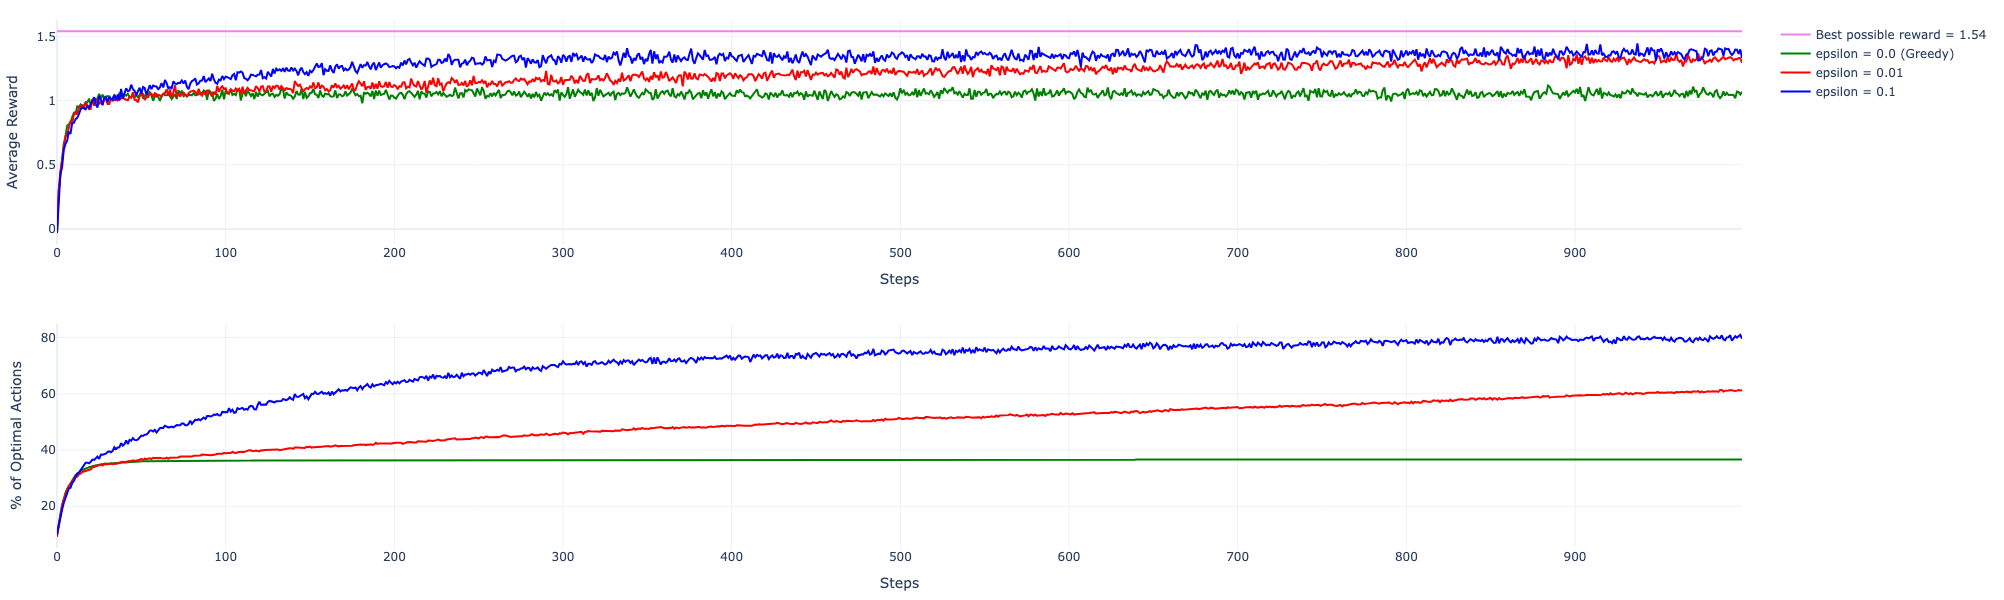

In [8]:
colors = ["green", "red", "blue"]

fig = make_subplots(rows=2, cols=1)

fig.add_trace(trace=go.Scatter(
    y=1.54 + np.zeros(shape=(1_000,)),
    marker=dict(color="violet"),
    name="Best possible reward = 1.54",
), row=1, col=1)

for i, agent in enumerate(agents):
    fig.add_trace(trace=go.Scatter(
        y=average_rewards[i],
        marker=dict(color=colors[i]),
        name=f"epsilon = {agent.epsilon} " + ("(Greedy)" if agent.epsilon == 0.0 else ""),
    ), row=1, col=1)
    
    fig.add_trace(trace=go.Scatter(
        y=optimal_action_pct[i],
        marker=dict(color=colors[i]),
        showlegend=False
    ), row=2, col=1)

fig.update_xaxes(title_text="Steps", row=1, col=1)
fig.update_xaxes(title_text="Steps", row=2, col=1)
fig.update_yaxes(title_text="Average Reward", row=1, col=1)
fig.update_yaxes(title_text="% of Optimal Actions", row=2, col=1)
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=600,
)
fig.show()

- **Greedy Method Performance**
    - Performs poorly in the long run, often stuck with suboptimal actions.
    - Found the optimal action in only about one-third of tasks.
    - Failed in the other two-thirds due to misleading early samples.
- **e-Greedy Methods Performance**
    - Perform better because they continue to explore.
    - $\varepsilon = 0.1$: Explores more, usually finds the optimal action earlier, but selects it at most 81% of the time.
    - $\varepsilon = 0.01$: Improves more slowly but eventually outperforms $\varepsilon = 0.1$ on long-term performance.
- **Effect of Reward Variance**
    - **High variance** (e.g., 10 instead of 1): More exploration is needed, favoring $\varepsilon$-greedy over greedy.
    - **Zero variance**: Greedy may perform best, since it can identify optimal actions quickly without exploration.
___

### 2.2. Exponential Recency-Weighted Average Method for Tracking Non Stationary Problem

In stationary bandit problems, where reward probabilities remain fixed, simple averaging methods are effective. However, real-world reinforcement learning problems are often nonstationary, meaning the reward probabilities change over time. In such cases, it is important to give more weight to recent outcomes than to those from the distant past. A widely used method for this is applying a constant step-size parameter. The incremental update rule becomes:

$$
Q_{n + 1} \doteq Q_n + \alpha \big[ R_n - Q_n \big],
$$

Where the step-size parameter $\alpha \in (0, 1]$ is constant. This results in $Q_{n+1}$ being a weighted average of past rewards and the initial estimate $Q_1$:

$$
\begin{aligned}
Q_{n + 1} &= Q_n + \alpha \big[ R_n - Q_n \big] \\ \\
&= Q_n + \alpha R_n - \alpha Q_n \\ \\
&= \alpha R_n + (1 - \alpha) Q_n \\ \\
&= \alpha R_n + (1 - \alpha) \big[ \alpha R_{n - 1} + (1 - \alpha) Q_{n - 1} \big] \\ \\
&= \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 Q_{n - 1} \\ \\
&= \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 \big[ \alpha R_{n - 2} + (1 - \alpha) Q_{n - 2} \big] \\ \\
&= \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 \alpha R_{n - 2} + (1 - \alpha)^3 Q_{n - 2} \\ \\
&= (1 - \alpha)^0 \alpha R_n + (1 - \alpha)^1 \alpha R_{n - 1} + (1 - \alpha)^2 \alpha R_{n - 2} + \cdots + (1 - \alpha)^{n - 1} \alpha R_1 + (1 - \alpha)^n Q_1 \\ \\
&= (1 - \alpha)^n Q_1 + \sum_{i = 1}^n \alpha (1 - \alpha)^{n - 1} R_i
\end{aligned}
$$

We call this a weighted average because the sum of the weights is $(1 - \alpha)^n + \sum_{i = 1}^n \alpha (1 - \alpha)^{n - 1} = 1$. In reinforcement learning, the step-size parameter can vary across steps. If we let $\alpha_n(a)$ represent the step size after the $n_{th}$ selection of action $a$:

- Using $\alpha_n(a) = \frac{1}{n}$ yields the **sample-average method** which, by the law of large numbers, converges to the true action values.
- In general, convergence is only guaranteed if the sequence ${\alpha_n(a)}$ satisfies two conditions (from stochastic approximation theory):
    - $\sum_{n = 1}^{\infty} \alpha_n(a) = \infty$: step sizes remain large enough to eventually overcome noise and initial bias
    - $\sum_{n = 1}^{\infty} \alpha_n^2(a) < \infty$: step sizes shrink enough to stabilize convergence

Both conditions are satisfied with the sample average $\alpha_n(a) = \frac{1}{n}$, but not with a constant step size $\alpha_n(a) = \alpha$:
- With a constant $\alpha$, the second condition fails, so the estimates never fully converge—they keep adapting to new rewards.
- This property is actually desirable in nonstationary environments, which are common in real-world reinforcement learning, because it allows the value estimates to remain responsive to recent changes.

Finally, although theoretically valid step-size sequences (satisfying both conditions) are important in analysis, in practice they often converge too slowly or require heavy tuning, so they are rarely used in applied RL.
____

In [9]:
%%time

environment = BanditNonStationaryEnvironment(n_actions=N_ACTIONS, seed=SEED)

agents = [
    BanditAgent(n_actions=N_ACTIONS, epsilon=0.1, seed=SEED),
    BanditStepSizeAgent(n_actions=N_ACTIONS, epsilon=0.1, step_size=0.1, seed=SEED)
]

experiment = BanditExperiment(environment=environment, n_runs=2_000, n_steps=10_000)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:46<00:00,  8.84it/s]

CPU times: user 7min 26s, sys: 1min 4s, total: 8min 31s
Wall time: 7min 37s


In [10]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(trace=go.Scatter(
    y=average_rewards[0],
    marker=dict(color="red"),
    name="epsilon = 0.1 - sample average",
), row=1, col=1)
fig.add_trace(trace=go.Scatter(
    y=average_rewards[1],
    marker=dict(color="blue"),
    name="epsilon = 0.1 - step size = 0.1",
), row=1, col=1)

fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[0],
    marker=dict(color="red"),
    showlegend=False
), row=2, col=1)
fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[1],
    marker=dict(color="blue"),
    showlegend=False
), row=2, col=1)

fig.update_xaxes(title_text="Steps", row=1, col=1)
fig.update_xaxes(title_text="Steps", row=2, col=1)
fig.update_yaxes(title_text="Average Reward", row=1, col=1)
fig.update_yaxes(title_text="% of Optimal Actions", row=2, col=1)
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=600,
)
fig.show()

A modified version of the 10-armed problem in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step) has been used.

- **Average reward:** constant step size clearly outperforms sample-average across the horizon.
- **% optimal action:** constant step size quickly climbs and reaches much higher (75-80%) vs. sample-average (45–50%).

**Why sample-average fails?**
- It weights all past rewards equally: an observation from 8,000 steps ago has weight $1/N$ just like a recent one.
- In a drifting environment, those stale observations pull $Q$ toward long-ago means → lag (tracking error) → worse action selection.

**Why constant step-size works**
- It uses exponential recency weighting: a reward $k$ steps old has weight $\alpha (1 - \alpha)^k$.
- Recent data dominate → $Q$ tracks current $q_*$ faster → more optimal choices and higher reward.
___

### 2.3. Optimistic Initial Values

All methods discussed so far are dependant to some extend on the initial action-values estimates $Q_1(a)$. $Q_1(a)$ introduces bias which can be beneficial for incorporating prior knowledge of the environment but requires user tuning.
- For the sample-average methods, it disappears once all actions have been selected at least once.
- For the exponential weighted average method (constant step size), the bias is permanent, though decreasing over time. Recall that $Q_n = (1 - \alpha)^n Q_1 + \sum_{i = 1}^n \alpha (1 - \alpha)^{n - 1} R_i$

To encourage exploration, optimistic initial values (e.g., setting $Q_1(a) = +5$ when true values average 0) promote trying multiple actions, as initial rewards disappoint and prompt switching. A greedy method with optimistic initials performs worse initially due to heavy exploration but better long-term, outperforming $\varepsilon$-greedy with zero initials on a 10-armed bandit problem.

However, optimistic initial values are a simple "trick" suited to stationary problems, not nonstationary ones where exploration needs persist. Sample-average methods similarly overemphasize initial conditions. Despite limitations, these straightforward techniques are often practical and widely used.
___

In [11]:
%%time

environment = BanditEnvironment(n_actions=N_ACTIONS, seed=SEED)

agents = [
    BanditStepSizeAgent(n_actions=N_ACTIONS, epsilon=0.1, step_size=0.1, seed=SEED),
    BanditOptimisticAgent(n_actions=N_ACTIONS, epsilon=0.0, step_size=0.1, initial_action_value=5.0, seed=SEED),
]

experiment = BanditExperiment(environment=environment, n_runs=2_000, n_steps=1_000)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 94.94it/s]

CPU times: user 39.9 s, sys: 9.36 s, total: 49.3 s
Wall time: 41.2 s


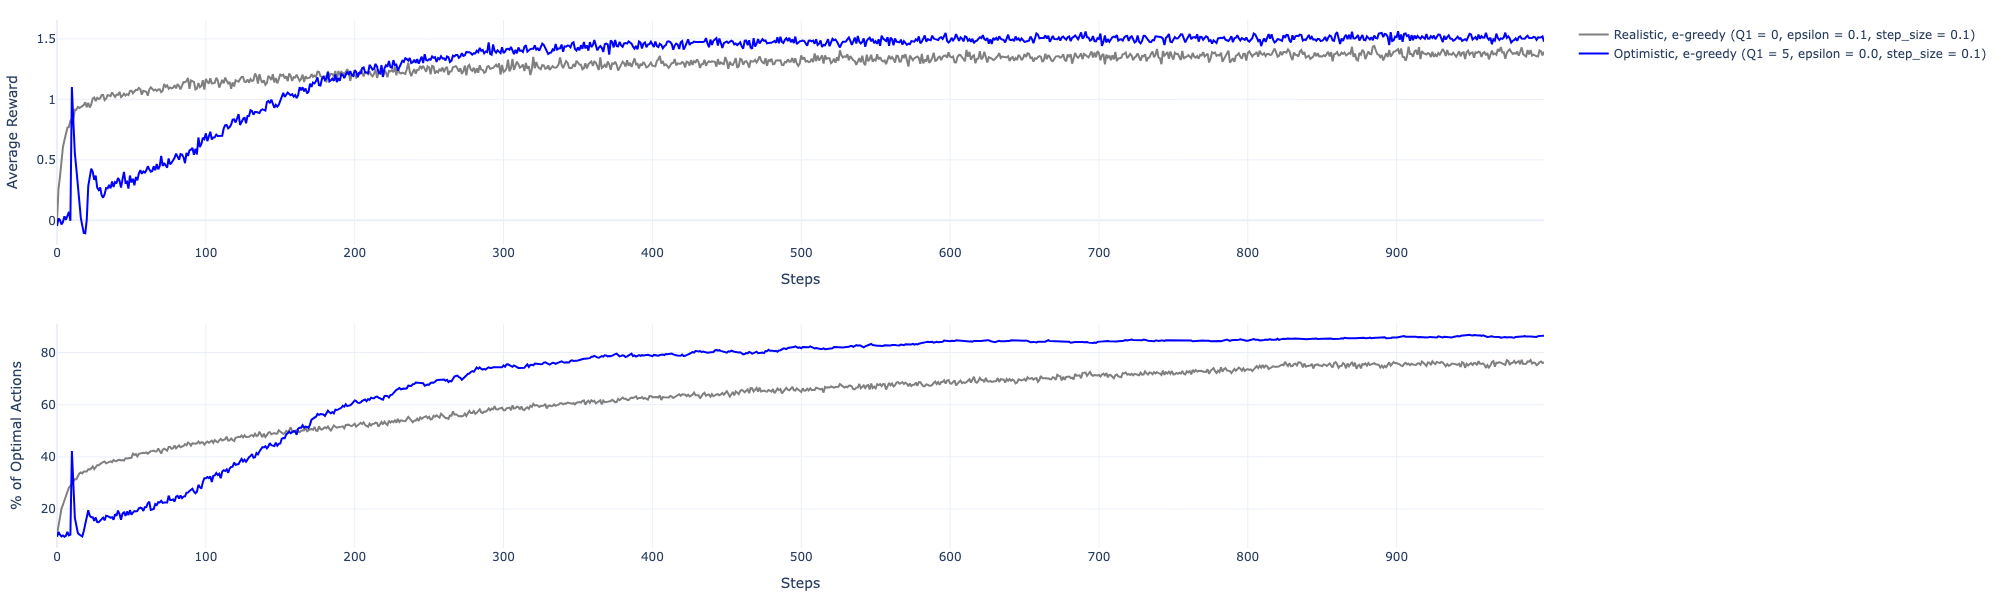

In [12]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(trace=go.Scatter(
    y=average_rewards[0],
    marker=dict(color="gray"),
    name="Realistic, e-greedy (Q1 = 0, epsilon = 0.1, step_size = 0.1)",
), row=1, col=1)
fig.add_trace(trace=go.Scatter(
    y=average_rewards[1],
    marker=dict(color="blue"),
    name="Optimistic, e-greedy (Q1 = 5, epsilon = 0.0, step_size = 0.1)",
), row=1, col=1)

fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[0],
    marker=dict(color="gray"),
    showlegend=False
), row=2, col=1)
fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[1],
    marker=dict(color="blue"),
    showlegend=False
), row=2, col=1)

fig.update_xaxes(title_text="Steps", row=1, col=1)
fig.update_xaxes(title_text="Steps", row=2, col=1)
fig.update_yaxes(title_text="Average Reward", row=1, col=1)
fig.update_yaxes(title_text="% of Optimal Actions", row=2, col=1)
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=600,
)
fig.show()

**Unbiased Constant Step Size Trick**

Although sample average methods do not introduce initial bias, they may perform poorly in nonstationary settings. It is possible to avoid the bias of constant step sizes while retaining their advantages in nonstationary settings. One way is to use a step size of:

$$
\beta_n \dot{=} \frac{\alpha}{\bar{o}_n},
$$

to process the $n_{th}$ reward for a particular action, where $\alpha > 0$ is a conventional constant step size, and $\bar{o}_n$ is a trace of one that starts at 0:

$$
\bar{o}_n \; \dot{=} \; \bar{o}_{n - 1} + \alpha (1 - \bar{o}_{n - 1}), \quad \text{for} \; n > 0, \quad \text{with} \; \bar{o}_0 \; \dot{=} \; 0.
$$

We will then have $Q_{n + 1} = Q_n + \beta_n (R_n - Q_n)$. After the first step, $Q_2 = Q_1 + \beta_1 (R_1 - Q_1)$.

$$
\beta_1 = \frac{\alpha}{\bar{o}_1} = \frac{\alpha}{\bar{o}_0 + \alpha (1 - \bar{o}_0)} = \frac{\alpha}{\alpha} = 1
$$

Then $Q_2 = Q_1 + (R_1 - Q_1) = R_1$. So any initialization $Q_1$ is erased immediately ie no bias right after the first step.

**Note:** $\beta$ also works on stationary settings: Assume i.i.d. rewards with mean $\mu = \mathbb{E}[R_n]$. Let $m_n = \mathbb{E}[Q_n]$. Since $\beta_n$ depends only on $n$,

$$
\begin{aligned}
m_n &= \beta_{n - 1} \mu + (1 - \beta_{n - 1}) m_{n - 1} \\ \\
m_n - \mu &= \beta_{n - 1} \mu + (1 - \beta_{n - 1}) m_{n - 1} - \mu \\ \\
m_n - \mu &= (1 - \beta_{n - 1}) (m_{n - 1} - \mu) \\ \\
m_n - \mu &= 0, \quad \text{since} \; \beta_1 = 1 \rightarrow \text{the product becomes 0} \\ \\
m_n &= \mu, \quad \text{regarless of} \; Q_1
\end{aligned}
$$
___

### 2.4. Upper-Confidence-Bound (UCB) Action Selection

Due to uncertainty in action-value estimates, exploration is essential beyond greedy selection, as seemingly inferior actions might actually be better. While $\epsilon$-greedy explores non-greedy actions randomly without preference, a more effective approach called **UCB Action Selection** choose actions based on the formula:

$$
A_t \; \dot{=} \; \arg \max_a \Big[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \Big],
$$

Where
- $Q_t(a)$ is the estimated value of action $a$,
- $N_t(a)$ is the count of times action $a$ has been selected before time $t$,
- $c > 0$ controls exploration degree,
- $\ln t$ is the natural logarithm of time $t$.

In UCB, the second term represents uncertainty, giving an upper confidence bound on action values. Actions with higher uncertainty or fewer selections are favored for exploration. Over time, uncertainty decreases as actions are tried more, but the logarithmic growth of the numerator ensures all actions are eventually selected. The scheme balances exploitation and directed exploration efficiently.

UCB works well in stationary k-armed bandit problems, often outperforming $epsilon$-greedy. However, it is more difficult to apply to:
- Nonstationary problems (requiring more complex methods),
- Large state spaces and function approximation contexts in general reinforcement learning, where UCB is impractical.

Thus, UCB is a sophisticated and effective exploration method for basic bandits but has limitations extending to broader reinforcement learning problems
___

In [48]:
%%time
environment = BanditEnvironment(n_actions=N_ACTIONS, seed=SEED)

agents = [
    BanditAgent(n_actions=N_ACTIONS, epsilon=0.1, seed=SEED),
    BanditUCBAgent(n_actions=N_ACTIONS, c=2, seed=SEED)
]

experiment = BanditExperiment(environment=environment, n_runs=2_000, n_steps=1_000)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.06it/s]

CPU times: user 1min 8s, sys: 11.1 s, total: 1min 20s
Wall time: 1min 11s


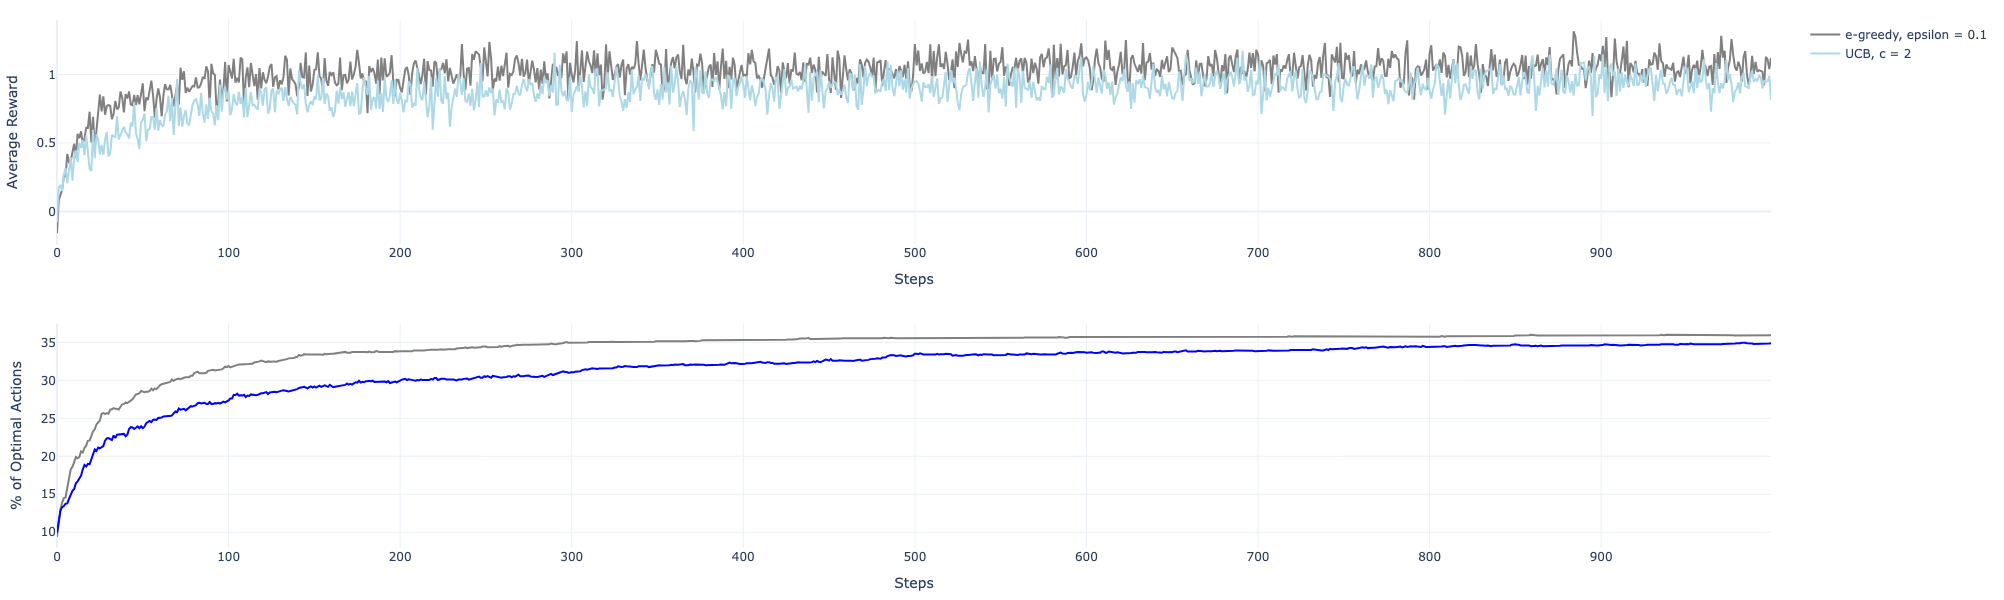

In [31]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(trace=go.Scatter(
    y=average_rewards[0],
    marker=dict(color="gray"),
    name="e-greedy, epsilon = 0.1",
), row=1, col=1)
fig.add_trace(trace=go.Scatter(
    y=average_rewards[1],
    marker=dict(color="blue"),
    name="UCB, c = 2",
), row=1, col=1)

fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[0],
    marker=dict(color="gray"),
    showlegend=False
), row=2, col=1)
fig.add_trace(trace=go.Scatter(
    y=optimal_action_pct[1],
    marker=dict(color="blue"),
    showlegend=False
), row=2, col=1)

fig.update_xaxes(title_text="Steps", row=1, col=1)
fig.update_xaxes(title_text="Steps", row=2, col=1)
fig.update_yaxes(title_text="Average Reward", row=1, col=1)
fig.update_yaxes(title_text="% of Optimal Actions", row=2, col=1)
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=600,
)
fig.show()

The UCB agent shows a distinct spike in performance on the $11{th}$ step:
- For the first 10 steps UCB must sample each untried arm once (their bonus is effectively $\rightarrow +\infty$).
- By step $t = 11$, every arm has $N_t(a) = 1$. The UCB bonus $c \sqrt{\ln t / N_t(a)}$ is then the same for all arms, so selection reduces to greedy on the first estimates: $a_11 = \arg \max_a Q_{10}(a)$.
- Picking the arm with the largest observed first reward yields a higher-than-average expected reward at that step (we’re exploiting the current best-looking arm). Hence the spike.

Then it dips on subsequent steps:
- After playing that best-looking arm at $t = 11$, its count becomes $N(a) = 2$, shrinking the bonus to $c \sqrt{\ln t / 2}$.
- The other nine arms still have $N(a) = 1$; as $t$ increases their bonuses $c \sqrt{\ln t / 1}$ stay larger. UCB therefore rotates back to explore those arms even if their current $Q$ is lower.
- his forced exploration of (often suboptimal) arms lowers the immediate average reward for a few steps, producing the post-spike dip.

**Generalizing:** with $K$ arms we get the spike at step $K + 1$ for the same reason—first moment we can exploit after one initial try of each arm, followed by renewed exploration.

### 2.5. Gradient Bandit Algorithm

Instead of estimating action values, another approach is to directly **learning numerical preferences** $H_t(a) \in \mathbb{R}$ for each action $a$, where higher values indicate greater likelihood of selection. These preferences lack direct reward interpretation; only relative differences matter (e.g., adding a constant to all preferences doesn't change behavior).

**Action Selection via Soft-Max**
- Action probabilities are computed using a soft-max (Gibbs/Boltzmann) distribution:
$$
P_r\{A_t = a\} \doteq \frac{e_{H_t(a)}}{\sum_{b=1}^k e_{H_t(b)}} \doteq \pi_t(a),
$$
- Initially, $H_1(a) = 0 \; \forall \; a$, yielding equal selection probabilities.

**Stochastic Gradient Ascent Learning Algorithm**
- Updates are based on stochastic gradient ascent after selecting action $ A_t $ and receiving reward $ R_t $:
    - For action selection: $$H_{t+1}(A_t) = H_t(A_t) + \alpha (R_t - \bar{R}_t) (1 - \pi_t(A_t))$$
    - For non-selected actions: $$H_{t+1}(a) = H_t(a) - \alpha (R_t - \bar{R}_t) \pi_t(a), \quad \forall \; a \neq A_t$$
- Parameters:
    - $\alpha > 0$: Step-size for updates.
    - $\bar{R}_t$: Baseline average of rewards up to (but excluding) time $t$ (which can be computed incrementally as $\bar{R}_t = R_{t - 1} + \frac{1}{t} (R_{t - 1} - \bar{R}_{t - 1})$; $\bar{R}_1 = R_1$).
- Mechanism: Compares $R_t$ to the baseline $\bar{R}_t$. If $R_t > \bar{R}_t$, the probability of selecting $A_t$ increases while others decrease (and vice versa), promoting exploration while favoring rewarding actions.
___

In [47]:
%%time

environment = BanditEnvironment(n_actions=N_ACTIONS, seed=SEED) # , reward_std=4.0

agents = [
    BanditGradientAgent(n_actions=N_ACTIONS, step_size=0.1, baseline=True, seed=SEED),
    BanditGradientAgent(n_actions=N_ACTIONS, step_size=0.4, baseline=True, seed=SEED),
    BanditGradientAgent(n_actions=N_ACTIONS, step_size=0.1, baseline=False, seed=SEED),
    BanditGradientAgent(n_actions=N_ACTIONS, step_size=0.4, baseline=False, seed=SEED),
]

experiment = BanditExperiment(environment=environment, n_runs=2_000, n_steps=1_000)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.24it/s]

CPU times: user 3min 16s, sys: 33.9 s, total: 3min 50s
Wall time: 3min 23s


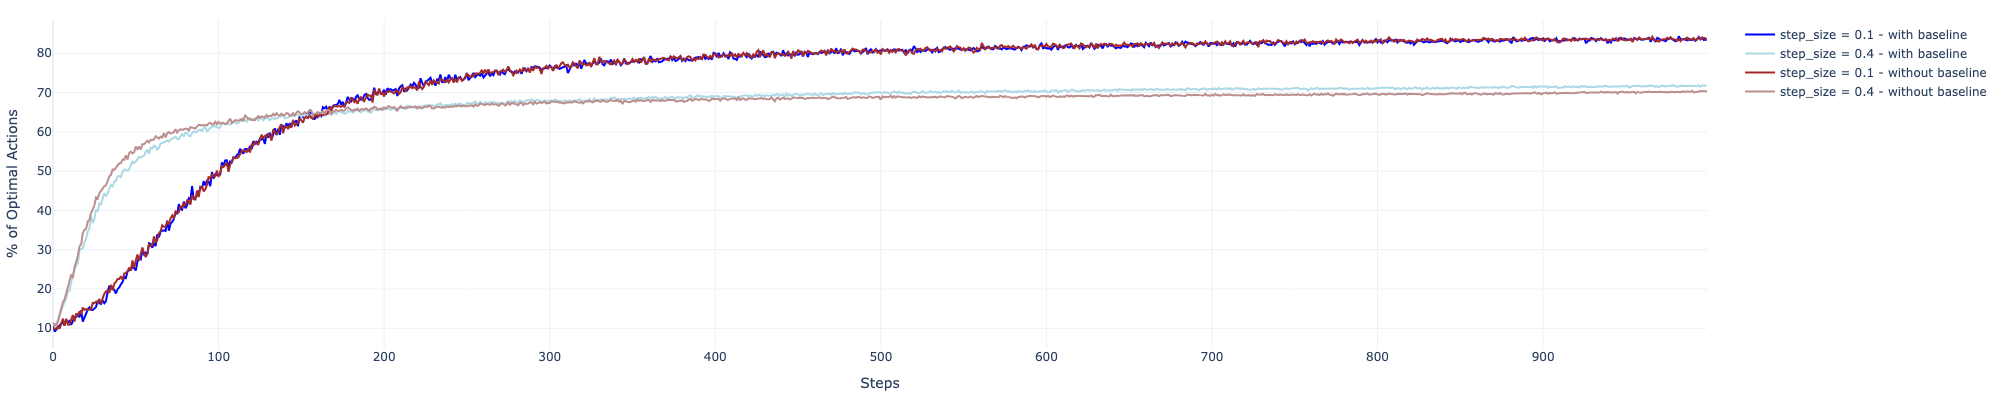

In [48]:
colors = ["blue", "lightblue", "brown", "rosybrown"]
descriptions = [
    "step_size = 0.1 - with baseline",
    "step_size = 0.4 - with baseline",
    "step_size = 0.1 - without baseline",
    "step_size = 0.4 - without baseline",
]

fig = go.Figure()
for i, agent in enumerate(agents):
    fig.add_trace(trace=go.Scatter(
        y=optimal_action_pct[i],
        marker=dict(color=colors[i]),
        name=descriptions[i],
    ))

fig.update_xaxes(title_text="Steps")
fig.update_xaxes(title_text="Steps")
fig.update_yaxes(title_text="Average Reward")
fig.update_yaxes(title_text="% of Optimal Actions")
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=400,
)
fig.show()

## 3. Associative Seearch - Contextual Bandit

___